# HW1: Simple base model

### Input files needed:
- topography.csv - grid of land surface elevations 
- watershed.csv - grid of no-flow cells indicating the watershed boundary

### MODFLOW packages used:
- DIS - Discretization input
- BAS - Basic
- LPF - Layer-Property Flow
- OC  - Output Control
- PCG - Preconditioned Conjugate Gradient
- RCH - Recharge
    
### Model description:
This is a steady-state model of the watershed shown below.

The model has 50x50 cells, each measuring 1000 m in x and in y.  
There are two homogeneous, isotropic layers. 
The model has a bottom elevation of 0 m (this is the datum elevation) and a top elevation that corresponds to the land surface elevation.
The land surface elevation in meters above the datum is provided in the topography.csv file.
The boundary between the two layers is flat and is at an elevation of 50 m above the datum.
The porosity is 0.10, specific yield is 0.10, and storage coefficient is 0.0001. 
The hydraulic conductivity is 10 m/day in all three principal directions (x,y,z).

The edges of the watershed are bounded by impermeable bedrock on three sides.  These are represented as no-flow cells (a type of boundary condition) provided by the watershed.csv file.
The right (eastern) boundary has a constant head of 70 m relative to the datum.

Recharge occurs at a rate of 4E-5 m/day in the leftmost (western) 15 columns and is zero elsewhere.  

## Import Python packages

In [46]:
import os
import numpy as np
import numpy.ma as ma
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Model setup

In [2]:
##Name:
modelname = "base"

##Grid:
nrow = 50          #number of rows
ncol = 50          #number of columns
delr = 1000.       #width of each cell along rows (so really this is column width along x axis)
delc = 1000.       #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 2                                                #number of layers
layers = np.arange(nlay)                                #make array of layers
ztop = np.genfromtxt('topography.csv', delimiter=',')   #import top elevation of top layer from csv file (dim: nrow,ncol)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((nlay,nrow,ncol),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = 50.                                       #replace the cell bottom elevations in the top layer (layer 0) with the elevation of the boundary between layers

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 10.    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 10.     #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1         #porosity
Ss = 0.0001      #storage coefficient
Sy = 0.1         #specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

In [3]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[0,:,:] =  np.genfromtxt('watershed.csv', delimiter=',')  #import locations of active and inactive cells from csv (slice layer index, all rows, all cols)
ibound[:,:,ncol-1] = -1     #replace rightmost (eastern) column (slice all layers, all rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
H_init = 70.                                #initial hydraulic head in meters
strt = np.full((nlay, nrow, ncol), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value

In [4]:
## Recharge conditions:
R = 4e-5                              #recharge rate [m/day]
rech = np.zeros((nrow,ncol))          #make array of zeros for recharge (dim: nrow, ncol, no layers because recharge only happens in top layer)
rech[:,0:15] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate

In [5]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to


### Display summary of model inputs

Model name: base
    Model grid: 2 layers x 50 rows x 50 cols;  Cell dimensions: 1000.0m x 1000.0m
    Storage properties: n = 0.1, Sy = 0.1, S = 0.0001
    Initial head: H = 70.0 m
    Recharge rate: R = 4e-05 m/day

Array shapes:
ztop (50, 50) ibound (2, 50, 50) strt (2, 50, 50) rech (50, 50)


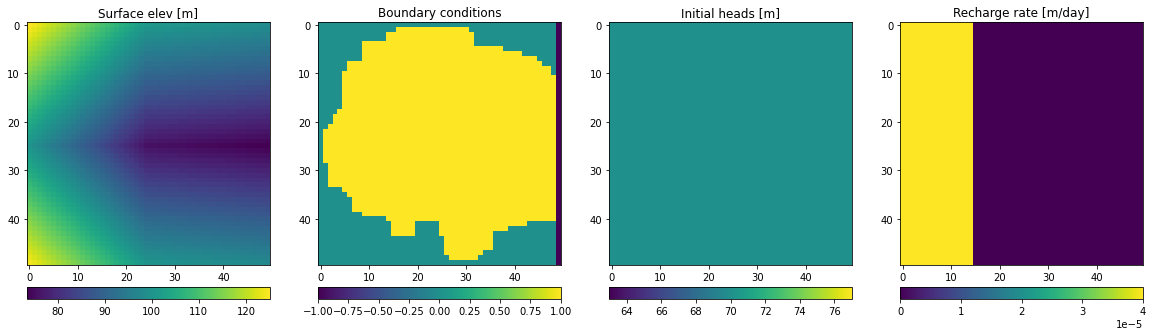

In [6]:
#Print model summary (change run to 'y' to run, 'n' to skip):

run = 'y'
if run == 'y':
    
    #Print parameter values:
    text = '''Model name: {}
    Model grid: {} layers x {} rows x {} cols;  Cell dimensions: {}m x {}m
    Storage properties: n = {}, Sy = {}, S = {}
    Initial head: H = {} m
    Recharge rate: R = {} m/day'''                                                #multi-line text to print
    print(text.format(modelname, nlay,nrow,ncol, delr,delc, n,Sy,Ss, H_init, R))  #parameter values to fill curly brackets above with

    #Print the dimensions of the arrays containing the parameters to check that they are correct:
    print('\nArray shapes:')                                                                       #print new line then text
    print('ztop', ztop.shape, 'ibound', ibound.shape, 'strt', strt.shape, 'rech', rech.shape)      #print the name of each array, then its shape
    
    #Plot spatial distribution of parameters:
    pars = [ztop,ibound[0,:,:],strt[0,:,:],rech]     #list the parameters we want to plot (we are only looking at top layer)
    parnames = ['Surface elev [m]', 'Boundary conditions','Initial heads [m]','Recharge rate [m/day]'] #create list of names for parameters
    f,ax = plt.subplots(nrows=1,ncols=len(pars),figsize=(20,12))  #create figure and axis objects with subplots for each parameter
    for ipar in np.arange(len(pars)):                             #loop over parameter list indices
        im = ax[ipar].imshow(pars[ipar][:,:])                     #plot map view of parameter distribution
        divider = make_axes_locatable(ax[ipar])                   #make axes dividable (to add colorbar)
        cax = divider.append_axes('bottom', size="5%", pad=0.3)   #add an axis at the bottom for the colorbar
        plt.colorbar(im, cax=cax, orientation='horizontal')       #plot the colorbar
        ax[ipar].set_title(parnames[ipar])                        #label each parameter

## Run model

In [7]:
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)

In [8]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/11/28 11:32:10

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/11/28 11:32:10
 Elapsed run time:  0.055 Seconds

  Normal termination of simulation


In [9]:
#Run MODPATH for particle tracking:
mp = flopy.modpath.Modpath(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.ModpathBas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound, prsity=n)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH


AttributeError: module 'flopy.modpath' has no attribute 'Modpath'

## Post-process results

In [11]:
##Get outputs:
#This section usually doesn't change much - ignore the FutureWarning

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)
#Get cell-by-cell outputs from cbb:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

#Get MODPATH outputs:    
endobj = flopy.utils.EndpointFile(modelname+'_mp.mpend')   #get the MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array
        

FileNotFoundError: [Errno 2] No such file or directory: 'base_mp.mpend'

In [20]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	        0.0
             RECHARGE_IN' 	    15400.0
                TOTAL_IN' 	    15400.0
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	   -15400.0
            RECHARGE_OUT' 	       -0.0
               TOTAL_OUT' 	   -15400.0
                  IN-OUT' 	        0.0
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


In [26]:
print(np.unique(head))
head_mx = ma.masked_values (head, -999.99)
print(np.unique(head_mx))

[-999.99      70.        72.04083 ...  121.67077  121.68782  121.68874]
[70.0 72.04083251953125 72.04364013671875 ... 121.68782043457031
 121.6887435913086 --]


[-999.99      70.        72.04083 ...  121.67077  121.68782  121.68874]
[70.0 72.04083251953125 72.04364013671875 ... 121.68782043457031
 121.6887435913086 --]


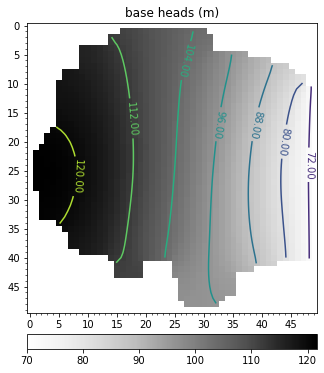

In [42]:
#Plot contour map of heads in Layer 1 at last timestep:

#Make a version of the head array where no-flow cells (cells outside the watershed boundary) are masked (invisible):
print(np.unique(head))                      #print a list of the unique values in the array (-999.99 indicates no-flow cells)
head_mx = ma.masked_values (head, -999.99)  #create a masked array where all cells with the value -999.99 are hidden
print(np.unique(head_mx))                    #print a list of unique values in the masked array (the no-flow cells are no longer visible)
      
#Create figure & plot data:
f,ax = plt.subplots(1,1,figsize=(6,6))        #create & return figure & axes at position (row, col) of size 6x6 inches
im = plt.imshow(head_mx[0,:,:], cmap='Greys') #plots heads as colors (all rows & columns in layer 0 of masked array)
c = plt.contour(head_mx[0,:,:], )             #plots heads as contours (all rows & columns in layer 0 of masked array)

#Labels:
plt.clabel(c, fmt='%1.2f', rightside_up=False)   #adds contour labels as floats with 2 decimal places, not oriented for reading   
plt.title(modelname+' heads (m)')                #adds a title

#Format grid & axes:
major_ticks = np.arange(0,nrow,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,nrow)           #creates an array for minor tick marks every 1

ax.set_xticks(major_ticks)             #sets major ticks
ax.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax1.grid(which='both')                  #turns grid on for both major and minor ticks

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.3)   #add an axis at the bottom for the colorbar
plt.colorbar(im, cax=cax, orientation='horizontal')       #plot the colorbar

(0.0, 125.0)

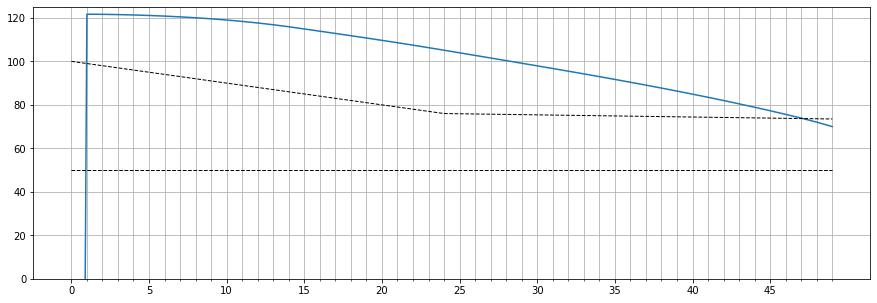

In [54]:
#Plot cross-section of heads along center row:
    
#Create figure & plot data:
f,ax = plt.subplots(1,1,figsize=(15,5))  #create a figure object of width 15 in and height 5 in, with two subplots
ax.plot(np.arange(ncol), head[0,nrow//2,:], c=) #plots heads at layer 0, center row, all columns

#Display layers:
ax.plot(np.arange(ncol), botm[1,nrow//2,:],'--k',linewidth=1)  #plot bottom elevation of middle layer as a thin dashed black line
ax.plot(np.arange(ncol), botm[0,nrow//2,:],'--k',linewidth=1)  #plot bottom elevation of top layer
ax.plot(np.arange(ncol), ztop[nrow//2,:],'--k',linewidth=1)    #plot top elevation of top layer

#Format grid & axes:
major_ticks = np.arange(0,nrow,5)      #creates an array for major tick marks every 5
minor_ticks = np.arange(0,nrow)        #creates an array for minor tick marks every 1
ax.set_xticks(major_ticks)             #sets major ticks
ax.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax.grid(which='both')                  #turns grid on for both major and minor ticks  
ax.set_ylim(bottom=zbot, top=np.amax(ztop))       #sets z limits to model bottom and highest top elev


NameError: name 'ept_array' is not defined

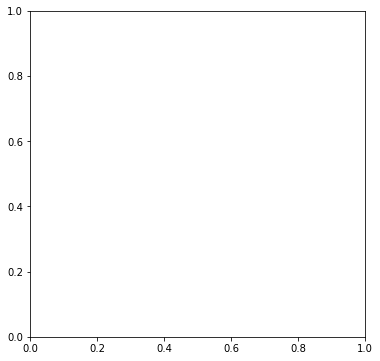

In [44]:
#Plot endpoints of particles:
#see https://pubs.usgs.gov/tm/6a41/pdf/TM_6A_41.pdf (p.33) 
#for information on what the columns of the endpoint file correspond to

run = 'y'
if run == 'y':

    f4,ax4 = plt.subplots(1,1,figsize=(6,6))                       #create & return figure & axes at position (row, col) of size 6x6 inches
    plt.scatter(ept_array[:,8],ept_array[:,7],marker='.',c='k')    #plot start locations in black
    plt.scatter(ept_array[:,20],ept_array[:,19],marker='.')        #plot end locations
    plt.title('Particle end locations')                            #add title


### Export data

In [52]:
np.savetxt('head_layer0.csv', head[0,:,:], delimiter=',')
np.savetxt('head_layer1.csv', head[1,:,:], delimiter=',')